In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from save_and_compare_results import *
import shap

In [2]:
X = pd.read_pickle("X_matrix_proteins_nb.pkl")
Y = pd.read_pickle("Y_matrix_proteins_nb.pkl")

In [3]:
# Preprocess the data
X = X.drop(columns=["Yeast_ID"]).fillna(0)
Y = Y.drop(columns=["Yeast_ID"]).fillna(Y.drop(columns=["Yeast_ID"]).mean())

In [6]:
param_grid = {
    "n_estimators": [100, 200, 500],  
    "max_depth": [10, 30],      
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 4],  
    "max_features": ["sqrt", "log2" ] 
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [7]:
print("Training of Random Forest with hyperparameters tuning")
grid_search.fit(X, Y.values.ravel())

Training of Random Forest with hyperparameters tuning
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=10, max_features=sqrt, m

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='r2', verbose=2)

In [8]:
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
print("\nBest hyperparameters :", best_params)


Best hyperparameters : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [9]:
y_pred = best_rf.predict(X)
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
print(f"\nR² Score: {r2:.4f}, Mean Squared Error: {mse:.4f}")


R² Score: 0.6012, Mean Squared Error: 0.0200


# Model features importance

Saving RF feature importances...
Feature importance saved to results/RandomForest_model_importance.csv
Displaying top 10 features...

Top 10 Features Impacting YPD Doubling Time:
             Feature  Importance
4799         YMR181C    0.062427
1056         YDR041W    0.045239
1601         YEL016C    0.018018
2583         YGR256W    0.012806
6262         YPL267W    0.011569
3978         YLR001C    0.010049
9111   YHR131W-A_CNV    0.009533
11619  YOL097W-A_CNV    0.009065
10653  YML009C-A_CNV    0.009047
556          YBR291C    0.008661


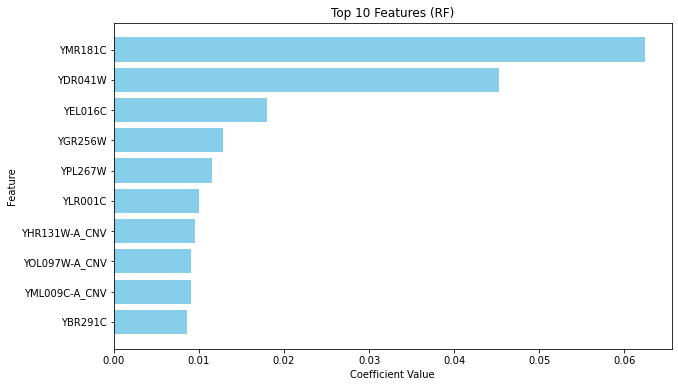

In [10]:
# Save feature importance from RF
print("Saving RF feature importances...")
save_feature_importance(
    features=X.columns,
    importance_scores=best_rf.feature_importances_,
    method="model",
    model_name="RandomForest"
)

# Display and plot the top 10 features
print("Displaying top 10 features...")
feature_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

top_features = feature_importances_df.head(10)

print("\nTop 10 Features Impacting YPD Doubling Time:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Features (RF)")
plt.gca().invert_yaxis()
plt.show()

# SHAP features importance

Calcul of SHAP values...
Saving SHAP feature importances for Random Forest...
Feature importance saved to results/RandomForest_SHAP_importance.csv
Generating SHAP summary plots for RF...


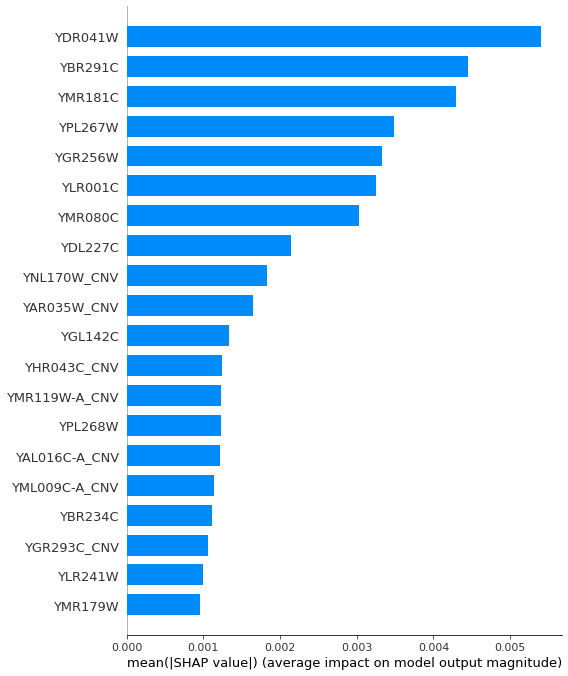

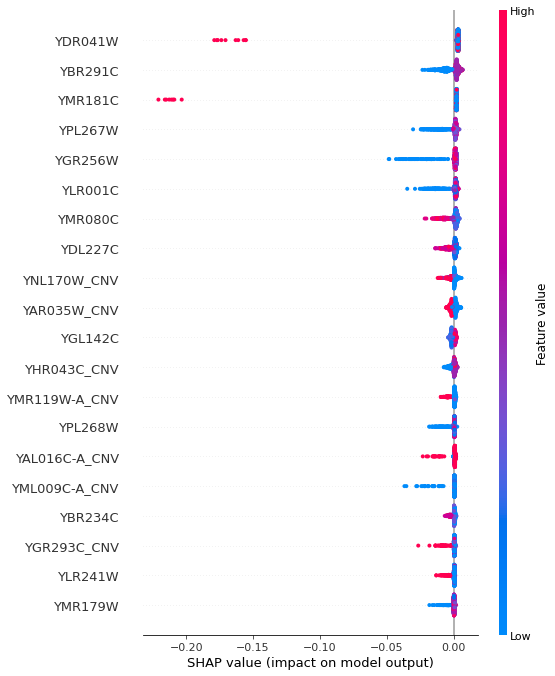

In [11]:
print("Calcul of SHAP values...")
explainer = shap.Explainer(best_rf, X)
shap_values = explainer(X)
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)

# Sauvegarder les importances SHAP
print("Saving SHAP feature importances for Random Forest...")
save_feature_importance(
    features=X.columns,
    importance_scores=shap_mean_importance,
    method="SHAP",
    model_name="RandomForest"
)

# %%
# Graphiques SHAP
print("Generating SHAP summary plots for RF...")
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)